# Cálculo de Churn y predicción de LTV

## Objetivo

En esta sección, abordaremos cómo calcular el churn de los clientes usando un enfoque basado en la frecuencia de compra y la inactividad. Luego, avanzaremos hacia la modelación predictiva para identificar los factores que más influyen en el LTV.

### Algoritmo para calcular el Customer Churn

1. **Preparación de los datos**:
   - Asegúrate de que el dataset incluye campos esenciales como el ID del cliente, la fecha de compra, y cualquier otro atributo relevante para el análisis, como el monto de la compra.

<br>

2. **Definir la fecha de corte**:
   - Establece una fecha de corte que representa el momento de análisis para determinar si un cliente ha dejado de ser activo.

<br>

3. **Calcula la frecuencia de las compras**:
   - Calcula la frecuencia de compra para cada cliente determinando el número de días entre compras consecutivas.

<br>

4. **Determina el threshold del Churn**:
   - Analiza la distribución del tiempo entre compras para todos los clientes.
   - Establece un umbral de churn utilizando el percentil 95 de estos tiempos para definir cuándo un cliente debería considerarse como churned.

<br>

5. **Etiqueta a los clientes como churned**:
   - Compara el tiempo desde la última compra de cada cliente hasta la fecha de corte con el threshold establecido. Etiqueta al cliente como churned si este tiempo supera el umbral definido.

<br>

6. **Análisis y reporte**:
   - Realiza un análisis del churn rate, considerando diferentes segmentaciones o factores demográficos.
   - Investiga profundamente para entender los factores que influyen en el churn y desarrolla estrategias orientadas a mejorar la retención de clientes.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from ucimlrepo import fetch_ucirepo

# Obtener dataset
online_retail = fetch_ucirepo(id=352)

# data (como dataframe de pandas)
X = online_retail.data.features.copy()
y = online_retail.data.targets

In [3]:
# metadata
print(online_retail.metadata)

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining', 'aut

In [4]:
# Información de las variables
print(online_retail.variables)

          name     role         type demographic  \
0    InvoiceNo       ID  Categorical        None   
1    StockCode       ID  Categorical        None   
2  Description  Feature  Categorical        None   
3     Quantity  Feature      Integer        None   
4  InvoiceDate  Feature         Date        None   
5    UnitPrice  Feature   Continuous        None   
6   CustomerID  Feature  Categorical        None   
7      Country  Feature  Categorical        None   

                                         description     units missing_values  
0  a 6-digit integral number uniquely assigned to...      None             no  
1  a 5-digit integral number uniquely assigned to...      None             no  
2                                       product name      None             no  
3  the quantities of each product (item) per tran...      None             no  
4  the day and time when each transaction was gen...      None             no  
5                             product price per uni

### Preparación de los datos

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Description  540455 non-null  object 
 1   Quantity     541909 non-null  int64  
 2   InvoiceDate  541909 non-null  object 
 3   UnitPrice    541909 non-null  float64
 4   CustomerID   406829 non-null  float64
 5   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 24.8+ MB


In [6]:
X.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
X['InvoiceDate'] = pd.to_datetime(X['InvoiceDate'])

In [8]:
# Sort data
X.sort_values(by=['CustomerID', 'InvoiceDate'])

X.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
X['LineTotal'] = X['Quantity']*X['UnitPrice']

customer_invoices = X.groupby(['CustomerID', 'InvoiceDate', 'Country'])['LineTotal'].sum().reset_index()
customer_invoices.head()

,CustomerID,InvoiceDate,Country,LineTotal
0,12346.0,2011-01-18 10:01:00,United Kingdom,77183.60
1,12346.0,2011-01-18 10:17:00,United Kingdom,-77183.60
2,12347.0,2010-12-07 14:57:00,Iceland,711.79
3,12347.0,2011-01-26 14:30:00,Iceland,475.39
4,12347.0,2011-04-07 10:43:00,Iceland,636.25


In [10]:
# Cuantos retornos exísten
sum(customer_invoices['LineTotal'] < 0)

3611

In [11]:
customer_invoices_clean = customer_invoices[customer_invoices['LineTotal'] > 0].copy()

### Definir la fecha de corte

In [12]:
snapshot_date = customer_invoices_clean['InvoiceDate'].max() 
snapshot_date

Timestamp('2011-12-09 12:50:00')

In [13]:
customer_invoices_clean['InvoiceDate'].min() 

Timestamp('2010-12-01 08:26:00')

### Calcula la frecuencia de las compras

In [14]:
# Calculate days between purchases
customer_invoices_clean['DaysBetweenPurchases'] = customer_invoices_clean.groupby(['CustomerID'])['InvoiceDate'].diff().dt.days
customer_invoices_clean.head()

,CustomerID,InvoiceDate,Country,LineTotal,DaysBetweenPurchases
0,12346.0,2011-01-18 10:01:00,United Kingdom,77183.60,NaN
2,12347.0,2010-12-07 14:57:00,Iceland,711.79,NaN
3,12347.0,2011-01-26 14:30:00,Iceland,475.39,49.0
4,12347.0,2011-04-07 10:43:00,Iceland,636.25,70.0
5,12347.0,2011-06-09 13:01:00,Iceland,382.52,63.0


In [15]:
customer_invoices_clean.describe()

,CustomerID,InvoiceDate,LineTotal,DaysBetweenPurchases
count,18410.000000,18410,18410.000000,14072.000000
mean,15266.278816,2011-07-01 12:26:35.240630272,483.541889,39.860858
min,12346.000000,2010-12-01 08:26:00,0.380000,0.000000
25%,13777.000000,2011-03-30 13:56:15,159.685000,6.000000
50%,15178.500000,2011-07-12 12:13:00,303.590000,22.000000
75%,16779.000000,2011-10-12 13:19:15,474.585000,51.000000
max,18287.000000,2011-12-09 12:50:00,168469.600000,365.000000
std,1733.927581,NaN,1685.409307,51.944454


### Determina el threshold del Churn

In [16]:
customer_invoices_clean['DaysBetweenPurchases'].quantile([0.8, 0.9, 0.95])

0.80     62.0
0.90    103.0
0.95    147.0
Name: DaysBetweenPurchases, dtype: float64

Observamos que es casi un tercio de año para considerarlo perdido, dado el poco tiempo de los datos quiza debemos ser mas conservadores y asumurlo perdido al percentil 90.

In [17]:
general_threshold = customer_invoices_clean['DaysBetweenPurchases'].quantile(0.90)
general_threshold

103.0

In [18]:
threshold_per_country = customer_invoices_clean.groupby('Country')['DaysBetweenPurchases'].agg(
    percentile_90=lambda x: x.quantile(0.90),
    transaction_count='count'
).reset_index()

threshold_per_country.head()

,Country,percentile_90,transaction_count
0,Australia,79.0,45
1,Austria,140.6,8
2,Bahrain,NaN,0
3,Belgium,86.8,74
4,Brazil,NaN,0


Usaremos por lo pronto el threshold general para aquellos paises que tengan menos de 15 transacciones.

In [20]:
threshold_per_country['threshold'] = threshold_per_country.apply(
    lambda row: general_threshold if row['transaction_count'] < 15 else row['percentile_90'],
    axis=1
)

threshold_per_country

,Country,percentile_90,transaction_count,threshold
0,Australia,79.0,45,79.0
1,Austria,140.6,8,103.0
2,Bahrain,NaN,0,103.0
3,Belgium,86.8,74,86.8
4,Brazil,NaN,0,103.0
5,Canada,19.3,2,103.0
6,Channel Islands,144.6,17,144.6
7,Cyprus,150.2,9,103.0
8,Czech Republic,221.0,1,103.0
9,Denmark,165.5,10,103.0


### Etiqueta a los clientes como churned

Con la nueva tabla de thresholds ahora hay que etiquetar a los clientes perdidos

In [22]:
last_invoice_date_per_customer = customer_invoices_clean.groupby(['Country','CustomerID'])['InvoiceDate'].max().reset_index().rename(columns={'InvoiceDate': 'LastInvoiceDate'})

last_invoice_date_per_customer.head()

,Country,CustomerID,LastInvoiceDate
0,Australia,12386.0,2011-01-06 12:37:00
1,Australia,12388.0,2011-11-24 12:30:00
2,Australia,12393.0,2011-09-28 15:41:00
3,Australia,12415.0,2011-11-15 14:22:00
4,Australia,12422.0,2011-09-05 09:48:00


In [23]:
customers = last_invoice_date_per_customer.merge(threshold_per_country, on='Country')
customers.head()

,Country,CustomerID,LastInvoiceDate,percentile_90,transaction_count,threshold
0,Australia,12386.0,2011-01-06 12:37:00,79.0,45,79.0
1,Australia,12388.0,2011-11-24 12:30:00,79.0,45,79.0
2,Australia,12393.0,2011-09-28 15:41:00,79.0,45,79.0
3,Australia,12415.0,2011-11-15 14:22:00,79.0,45,79.0
4,Australia,12422.0,2011-09-05 09:48:00,79.0,45,79.0


In [24]:
customers['inactivity_days'] = (snapshot_date - customers['LastInvoiceDate']).dt.days
customers['churned'] = (customers['inactivity_days'] > customers['threshold']).astype('int')

customers.head()

,Country,CustomerID,LastInvoiceDate,percentile_90,transaction_count,threshold,inactivity_days,churned
0,Australia,12386.0,2011-01-06 12:37:00,79.0,45,79.0,337,1
1,Australia,12388.0,2011-11-24 12:30:00,79.0,45,79.0,15,0
2,Australia,12393.0,2011-09-28 15:41:00,79.0,45,79.0,71,0
3,Australia,12415.0,2011-11-15 14:22:00,79.0,45,79.0,23,0
4,Australia,12422.0,2011-09-05 09:48:00,79.0,45,79.0,95,1


<Axes: xlabel='Country'>

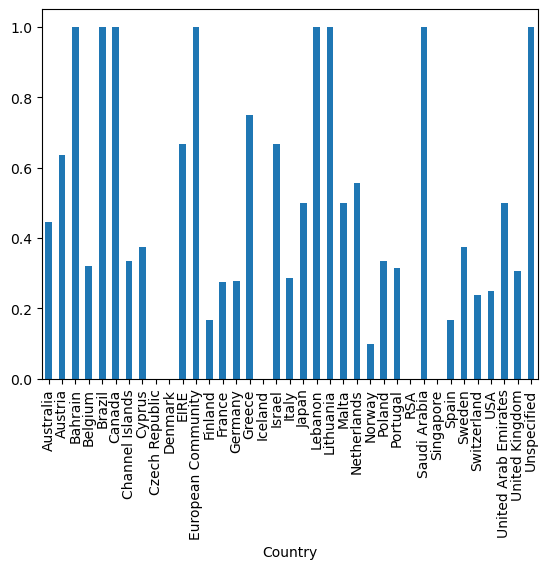

In [25]:
customers.groupby('Country')['churned'].mean().plot(kind='bar')

## Algoritmo para predecir el LTV a 24 meses

### Preparación de los datos

1. **Colección y limpieza de datos:**
    - Asegurarse de que los datos incluyan información relevante como demografía del cliente, historial de compras y métricas de interacción.
    - Limpiar los datos para manejar valores faltantes, outliers y consistencia de formatos.
    - Define y calcula la variable objetivo.

### Ingeniería de características

2. **Creación de características:**
    - Crear características que reflejen el comportamiento del cliente, tales como el gasto total, la cantidad promedio de transacciones, la frecuencia de compra, y el tiempo desde la última compra.
    - Considerar la creación de características en ventanas de tiempo como el gasto total en los últimos 6 o 12 meses.

### Análisis exploratorio de datos (EDA)

3. **Análisis exploratorio:**
    - Analizar los datos para entender patrones y relaciones.
    - Visualizar las distribuciones del gasto y otras métricas relevantes a través de diferentes segmentos de clientes.
    - Agrupar clientes basándose en la fecha de su primera compra y seguir su comportamiento a lo largo del tiempo.


### Modelado predictivo

4. **Modelado predictivo:**
    - Dividir los datos en conjuntos de entrenamiento y prueba.
    - Elegir un modelo de regresión adecuado para predecir un resultado continuo como el LTV.
    - Entrenar el modelo en los datos de entrenamiento utilizando las características desarrolladas.

### Evaluación del modelo

5. **Evaluación del modelo:**
    - Evaluar el modelo en el conjunto de prueba usando métricas adecuadas, como el error cuadrático medio (RMSE) o el error absoluto medio (MAE).
    - Analizar los residuales para asegurar que el modelo funciona bien en todos los segmentos de clientes.

### Interpretación del modelo y aplicación de insights

6. **Interpretación y acción:**
    - Interpretar el modelo para entender qué características son más predictivas del LTV.
    - Usar la salida del modelo para segmentar clientes basándose en su LTV predicho y dirigirles estrategias de marketing específicas.

### Despliegue y monitoreo

7. **Despliegue y monitoreo:**
    - Implementar el modelo en un entorno de producción donde pueda predecir el LTV de nuevos clientes.
    - Monitorear regularmente el desempeño del modelo y actualizarlo según sea necesario para manejar cambios en el comportamiento del cliente o en las condiciones del mercado.